<h1>Analiza częstotliwości występowania słów w kilku językach i tekstach</h1>

Niniejszy raport przedstawia porównanie częstotliwości występowania słów w dwóch artykułach na Wookiepedii oraz w dłuższych tekstach w językach polskim, angielskim i francuskim. Porównuje następnie tę częstotliwość z częstotliwościami występowania słów we wszystkich trzech językach i na tej podstawie próbuje wyznaczyć zgodność tekstu z każdym z trzech języków.

<h3>Funkcja wyliczająca zgodność tekstu z językiem</h3>

Funkcja liczy „iloczyn skalarny wektorów słów” w tekście oraz w języku i normalizuje go. Z nierówności Schwarza i nieujemności wszytkich częstotliwości wiemy, że tak wyznaczona wielkość powinna znaleźć się między zerem a jedynką. Wielkości bliskie zeru oznaczają małą zgodność, wielkości zaś bliskie jedynce oznaczają dużą zgodność.

In [148]:
def lang_confidence_score(word_counts, language_words_with_frequency):
    sum_squares_art = 0
    sum_squares_lang = 0
    dot_product = 0
    for word, count in word_counts.items():
        if word in language_words_with_frequency.keys():
            count_lang = language_words_with_frequency[word]
        else:
            count_lang = 0

        sum_squares_art += count ** 2
        sum_squares_lang += count_lang ** 2
        dot_product += count * count_lang

    return dot_product ** 2 / (sum_squares_art * sum_squares_lang)

<h3>Załadowanie artykułów z Wookiepedii</h3>

Korzystając z wiki_scraper.py, scrape'uję tutaj dwa artykuły z Wookiepedii - jeden o Obi-wanie Kenobim, a drugi minimalizujący dopasowanie z językiem angielskim. Po przeszukaniu 50 artykułów, okazało się, że takim jest artykuł o ??????

Wyniki zliczeń słów zapisuję jako wejścia w tabeli word_counts.

In [ ]:
import json
import os
from types import SimpleNamespace

# Check if wiki_scraper exists, otherwise mock it for safety
try:
    import wiki_scraper
except ImportError:
    wiki_scraper = None
    print("Warning: 'wiki_scraper' module not found. Skipping web scraping.")

word_counts = {}

if wiki_scraper:
    # Obi-wan Kenobi
    args = SimpleNamespace(
        summary=None, table=None, number=None,
        count_words="Obi-wan Kenobi", analyze_relative_word_frequency=None,
        mode=None, count=None, chart=None, auto_count_words=None,
        depth=None, wait=None
    )

    file_path = "word-counts.json"
    # Ensure fresh start
    if os.path.exists(file_path):
        os.remove(file_path)

    # Run manager
    try:
        manager = wiki_scraper.Manager(args)
        manager.action()

        if os.path.exists(file_path):
            with open(file_path, "r", encoding="utf-8") as f:
                data = json.load(f)
                # Ensure the key exists before accessing
                word_counts["obi-wan-kenobi"] = data.get("words", {})
    except Exception as e:
        print(f"Error running wiki_scraper: {e}")

    # Darth Vader (for now)
    args = SimpleNamespace(
        summary=None, table=None, number=None,
        count_words="Darth Vader", analyze_relative_word_frequency=None,
        mode=None, count=None, chart=None, auto_count_words=None,
        depth=None, wait=None
    )

    # Ensure fresh start
    if os.path.exists(file_path):
        os.remove(file_path)

    # Run manager
    try:
        manager = wiki_scraper.Manager(args)
        manager.action()

        if os.path.exists(file_path):
            with open(file_path, "r", encoding="utf-8") as f:
                data = json.load(f)
                # Ensure the key exists before accessing
                word_counts["darth-vader"] = data.get("words", {})
    except Exception as e:
        print(f"Error running wiki_scraper: {e}")

<h3>Pobranie danych z dłuższych tekstów</h3>

Teraz pobieram dane z przygotowanych wcześniej dłuższych tekstów we wszystkich trzech językach. Jak poprzednio, zapisuję zliczenia słów jako wejścia w tabeli word_
counts.

In [ ]:
import re

languages = ["en", "pl", "fr"]

for lang in languages:
    path = f"texts/{lang}.txt"
    if os.path.exists(path):
        with open(path, "r", encoding="utf-8") as f:
            content = f.read()
            # Regex to find words, ignoring punctuation
            words = re.findall(r'\b\w+\b', content.lower(), flags=re.UNICODE)

            counts = {}
            for word in words:
                counts[word] = counts.get(word, 0) + 1
            word_counts[lang] = counts
    else:
        print(f"Warning: File '{path}' not found. Using empty data.")
        word_counts[lang] = {}

<h3>Porównanie wyników ze słownikami</h3>

Po zebraniu danych o wszystkich tekstach, porównuję je ze słownik

In [158]:
from collections import defaultdict
from wordfreq import word_frequency, top_n_list

print(f"\n{'K':<6} {'Ref Lang':<10} {'Text Source':<15} {'Consistency Score'}")
print("-" * 50)

consistency = defaultdict(lambda: defaultdict(dict))
k_values = [3, 10, 100, 1000]

for k in k_values:
    # Reference frequencies for all languages for current K
    words_lang_ref = {
        lang: {word: word_frequency(word, lang) for word in top_n_list(lang, k)}
        for lang in languages
    }

    for ref_lang in languages:
        ref_data = words_lang_ref[ref_lang]
        for text_source, text_data in word_counts.items():
            if not text_data:
                continue

            # The defaultdict handles the creation of missing keys automatically
            score = lang_confidence_score(text_data, ref_data)
            consistency[k][ref_lang][text_source] = score

            print(f"{k:<6} {ref_lang:<10} {text_source:<15} {score:.5f}")

Content from Wookieepedia: Obi-wan Kenobi
Source: https://starwars.fandom.com/wiki/Obi-wan_Kenobi
License: CC BY-SA 3.0
Content from Wookieepedia: Darth Vader
Source: https://starwars.fandom.com/wiki/Darth_Vader
License: CC BY-SA 3.0

K      Ref Lang   Text Source     Consistency Score
--------------------------------------------------
3      en         obi-wan-kenobi  0.64673
3      en         darth-vader     0.66044
3      en         en              0.48941
3      en         pl              0.02245
3      en         fr              0.00000
3      pl         obi-wan-kenobi  0.00032
3      pl         darth-vader     0.00033
3      pl         en              0.00082
3      pl         pl              0.36295
3      pl         fr              0.00000
3      fr         obi-wan-kenobi  0.00000
3      fr         darth-vader     0.00000
3      fr         en              0.00000
3      fr         pl              0.00000
3      fr         fr              0.34535
10     en         obi-wan-kenobi

<h3>Zapisanie do trójwymiarowej tablicy</h3>

Uzyskane wartości zgodności zapisuję do trójwymiarowej tablicy, celem sporządzenia później wykresu.

In [159]:
import numpy as np

text_sources_list = list(word_counts.keys())
data_3d = np.zeros((len(k_values), len(languages), len(text_sources_list)))

for i, k in enumerate(k_values):
    for j, lang in enumerate(languages):
        for m, source in enumerate(text_sources_list):
            data_3d[i, j, m] = consistency[k][lang].get(source, 0)

<h3>Wykresy</h3>

Wykresy - po jednym dla każdej wartości k - przedstawiające ze wszystkimi językami kolejnych tekstów.

Zgodnie z oczekiwaniami, stopień dopasowania z danym językiem jest wyraźnie wyższy dla tekstów pochodzących z danego języka (dla k = 1000 jest to w każdym przypadku ponad 70%) niż dla tekstów pochodzących z innego języka (ta liczba nie przekracza nigdzie 10%).

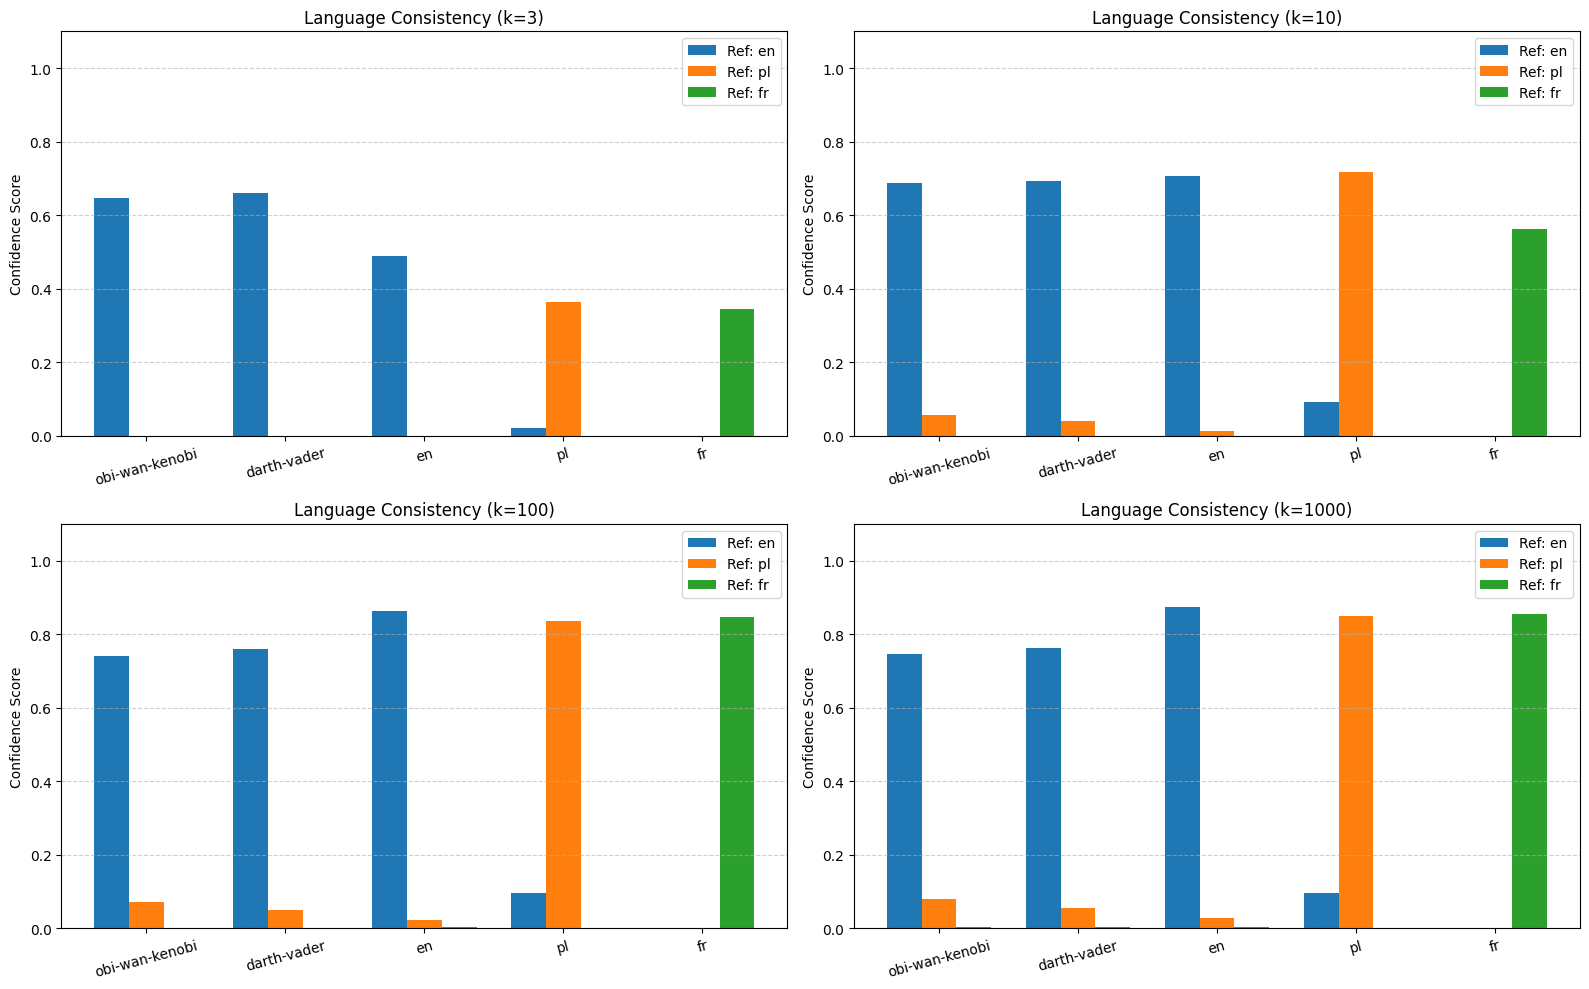

In [161]:
from matplotlib import pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(16,10))
axes = axes.flatten()

for i, k in enumerate(k_values):
    ax = axes[i]
    x = np.arange(len(text_sources_list))
    width = .25

    for j, lang in enumerate(languages):
        scores = [consistency[k][lang].get(source, 0) for source in text_sources_list]
        ax.bar(x + j * width, scores, width, label=f"Ref: {lang}")

        ax.set_title(f"Language Consistency (k={k})")
        ax.set_xticks(x + width)
        ax.set_xticklabels(text_sources_list, rotation=15)
        ax.set_ylabel("Confidence Score")
        ax.set_ylim(0, 1.1) # Scores are usually 0-1
        ax.legend()
        ax.grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

Jak wynika z zebranych danych, dla każdego języka, porównanie jego słownika z częstotliwościami występowania słów w tym języku, jak i z częstotliwościami występowania słów w innych językach, wygląda podobnie. Nie zaobserwowano znaczącej korelacji między językiem a stopniem dopasowania tekstów w tym języku ze słownikiem tego języka. Należałoby więc stwierdzić, że dobór języków nie miał większego znaczenia.

W szczególności, dane zdają się nie zależeć w większym stopniu od tego, czy słowa w danym języku są często odmieniane. Wiadomo przecież, że tak jest w języku polskim, ale już niekoniecznie w angielskim.